In [51]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import plot_roc_curve

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics.pairwise import linear_kernel
from sklearn.decomposition import NMF, PCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (confusion_matrix, precision_score, 
                                    recall_score, accuracy_score, r2_score, 
                                    plot_confusion_matrix, auc, roc_curve, roc_auc_score)

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, plot_confusion_matrix
from sklearn.cluster import DBSCAN

from sklearn import (
    cluster, decomposition, ensemble, manifold, 
    random_projection, preprocessing)
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB

# from sklearn.neighbors import KNeighborsRegressor

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import pickle
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import random

# ALL DONE WITH UNDERSAMPLING

In [2]:
df = pd.read_csv('../../../cleaned_comments.csv')

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.rating, stratify = df.rating, test_size=0.06)
y_train.value_counts()
#Rejected values utilize only 7 percent of the overall available data

len(y_test)/(len(y_test)+len(y_train))

0.06000002214451956

In [4]:
train_df = pd.concat([X_train, y_train], axis = 1)
ap_df = train_df[train_df.rating ==1]
rej_df = train_df[train_df.rating == 0]
#check your work
ap_df.rating.value_counts(), rej_df.rating.value_counts()

(1    1584507
 Name: rating, dtype: int64,
 0    113430
 Name: rating, dtype: int64)

In [6]:
#try to undersampling the majority class?
min_val = rej_df.rating.value_counts()[0]
r = np.random.RandomState(42)
inds = np.arange(min_val)
r.shuffle(inds)
rej_df1=rej_df.iloc[inds]
ap_df1=ap_df.iloc[inds]
#put indices in a random order for selection
fixed_train_df = pd.concat([rej_df1, ap_df1], axis = 0)

In [7]:
shuffled_df = fixed_train_df.sample(frac=1)

In [8]:
X_train = shuffled_df.text.values
y_train = shuffled_df.rating.values
shuffled_df.rating.value_counts()

1    113430
0    113430
Name: rating, dtype: int64

In [13]:
print(f'testing size = {len(y_test)/(len(y_train)+len(y_test))}')

testing size = 0.3232887581695447


# Original TFDIF with Random Forest

In [73]:
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english', analyzer='word', strip_accents='ascii',sublinear_tf = True)
x_train_vect = vectorizer.fit_transform(X_train)
x_test_vect = vectorizer.transform(X_test.values)


model = RandomForestClassifier(n_jobs=-1, 
                               random_state  = 1,
                               max_depth = 4, 
                               n_estimators=500, 
                              max_features = 500, 
                              min_samples_split = 2,
                              bootstrap = True,
                              min_samples_leaf = 1, class_weight = 'balanced')
model.fit(x_train_vect, y_train)

# max_depth            | 4        | [3, 2, 4]
# min_samples_split    | 2        | [2, 4]
# min_samples_leaf     | 1        | [1, 2, 4]
# bootstrap            | True     | [True, False]

RandomForestClassifier(class_weight='balanced', max_depth=4, max_features=500,
                       n_estimators=500, n_jobs=-1, random_state=1)

In [74]:
orf_y_pred = model.predict(x_test_vect)

accuracy_score(y_test, orf_y_pred ), \
    precision_score(y_test, orf_y_pred ), \
           recall_score(y_test, orf_y_pred )

(0.8959023427047675, 0.9398932785039409, 0.9491491907177251)

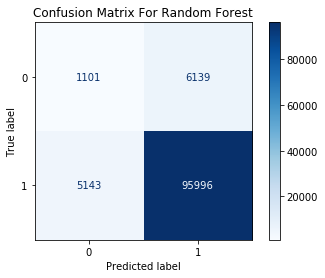

In [75]:
plot_confusion_matrix(model,x_test_vect, y_test, cmap = plt.cm.Blues)
plt.title('Confusion Matrix For Random Forest')
# plt.savefig('')
plt.show()

## Original TFDIF with ComplementNB

In [66]:
cnb = ComplementNB()
cnb.fit(x_train_vect, y_train)
# filename = 'balanced_cnb_model.sav'
# pickle.dump(nb, open(filename, 'wb'))


ocnb_y_pred = cnb.predict(x_test_vect)

accuracy_score(y_test, ocnb_y_pred), \
    precision_score(y_test, ocnb_y_pred), \
           recall_score(y_test, ocnb_y_pred)

(0.6511870380793328, 0.9629142364308789, 0.6513016739338929)

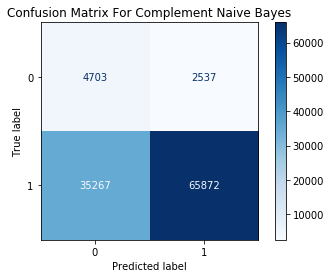

In [41]:
plot_confusion_matrix(cnb,x_test_vect, y_test, cmap = plt.cm.Blues)
plt.title('Confusion Matrix For Complement Naive Bayes')
# plt.savefig('cnb_con_mx.png')
plt.show();

# Optimized TFDIF with Random Forest

In [18]:
new_vectorizer = TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                encoding='utf-8',
                input='content', lowercase=True, max_df=0.25, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

x_train_nvect = new_vectorizer.fit_transform(X_train)
x_test_nvect = new_vectorizer.transform(X_test.values)



rf = RandomForestClassifier(n_jobs=-1, 
                               random_state  = 1,
                               max_depth = 4, 
                               n_estimators=500, 
                              max_features = 500, 
                              min_samples_split = 2,
                              bootstrap = True,
                              min_samples_leaf = 1)
rf.fit(x_train_nvect, y_train)

# max_depth            | 4        | [3, 2, 4]
# min_samples_split    | 2        | [2, 4]
# min_samples_leaf     | 1        | [1, 2, 4]
# bootstrap            | True     | [True, False]

RandomForestClassifier(max_depth=4, max_features=500, n_estimators=500,
                       n_jobs=-1, random_state=1)

In [67]:
nrfy_pred = rf.predict(x_test_nvect)

accuracy_score(y_test, nrfy_pred), \
    precision_score(y_test, nrfy_pred), \
           recall_score(y_test, nrfy_pred)

(0.5573219904224989, 0.9642482883889898, 0.5458725120873253)

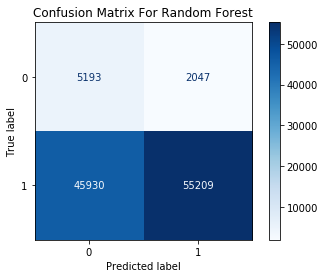

In [24]:
plot_confusion_matrix(rf,x_test_nvect, y_test, cmap = plt.cm.Blues)
plt.title('Confusion Matrix For Random Forest')
# plt.savefig('')
plt.show()

# Optimized TFDIF with Random Forest

In [68]:
new_cnb = ComplementNB()
new_cnb.fit(x_train_nvect, y_train)
# filename = 'balanced_cnb_model.sav'
# pickle.dump(nb, open(filename, 'wb'))


ncnby_pred = new_cnb.predict(x_test_nvect)

accuracy_score(y_test, ncnby_pred), \
    precision_score(y_test, ncnby_pred), \
           recall_score(y_test, ncnby_pred)

(0.7189584698142629, 0.9704222352377403, 0.7208099743916788)

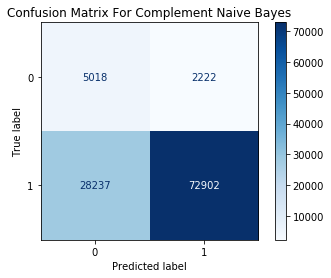

In [61]:
plot_confusion_matrix(new_cnb,x_test_nvect, y_test, cmap = plt.cm.Blues)
plt.title('Confusion Matrix For Complement Naive Bayes')
# plt.savefig('cnb_con_mx.png')
plt.show();

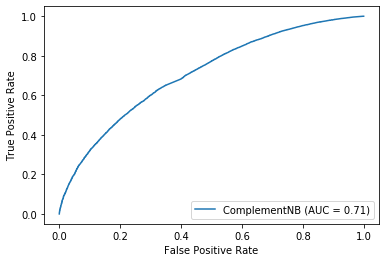

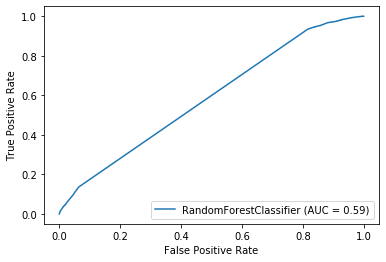

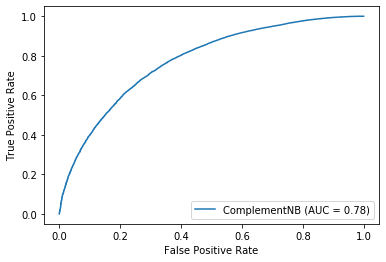

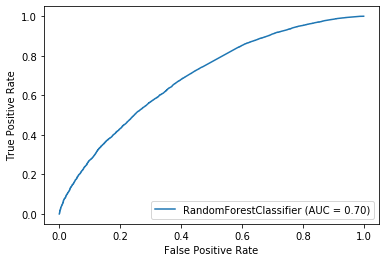

In [71]:
plot_roc_curve(cnb, x_test_vect, y_test)
plot_roc_curve(model, x_test_vect, y_test)
plot_roc_curve(new_cnb, x_test_nvect, y_test)
plot_roc_curve(rf, x_test_nvect, y_test)


## PLOT ROCs

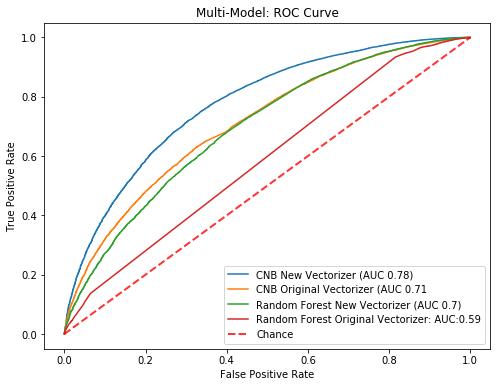

In [72]:
fig, ax = plt.subplots(1, figsize = (8,6))
plot_roc_curve(new_cnb, x_test_nvect, y_test, ax = ax, \
               label = f'CNB New Vectorizer (AUC {0.78})')


plot_roc_curve(cnb, x_test_vect, y_test, ax = ax, \
               label = f'CNB Original Vectorizer (AUC {0.71}')

plot_roc_curve(rf, x_test_nvect, y_test, ax = ax, \
               label = f'Random Forest New Vectorizer (AUC {0.70})')


plot_roc_curve(model, x_test_vect, y_test, ax = ax, \
               label = f'Random Forest Original Vectorizer: AUC:{0.59}')


ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.legend()
plt.title('Multi-Model: ROC Curve')
# plt.savefig('')
plt.show()